In [1]:
import numpy as np
import pandas as pd
import math
import scipy.stats
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
pd.options.display.float_format = '{:.3f}'.format

/home/owen/bin/anaconda3/envs/geo_env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
def print_nulls(df):
    
    return df.isnull().sum()*100/df.isnull().isnull().count()

## What we know about the data already

I merged the data from the indego website https://www.rideindego.com/about/data/

The data ranges from the start of the program in _start_date_ 2015 through to _end date_2020_. Per the website above trips shorter than 1 minute have been removed and trip length has been capped at 24 hours. I will keep this in mind as I consider outliers. 

We do not have any information other than start and end points, about the routes that riders took.

We also must consider that this is a biased dataset. These data represents a specific population of bikers. 

In [3]:
raw_data = pd.read_csv(r'data/indego/indego-trips-all.csv')

/home/owen/bin/anaconda3/envs/geo_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (5,6,8,9,10,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df = raw_data.copy()

In [5]:
# Type errors let us know that we may have some problems with missing or improperly typed data. 
# We already know this from merging our data.

In [6]:
# Drop the unique identifier
df.drop('trip_id', axis=1, inplace=True)

## Data Cleaning

In [7]:
# Encode trip type
mask = df['trip_route_category'] == 'One Way'
df.loc[mask, 'trip_route_category'] = 0

mask = df['trip_route_category'] == 'Round Trip'
df.loc[mask, 'trip_route_category'] = 1

df['trip_route_category'] = pd.to_numeric(df['trip_route_category'])

In [8]:
# Check how ballanced our level are in some of our categorical variables
df['passholder_type'].value_counts()

Indego30        2722416
Walk-up          319259
Indego365        299087
Day Pass         215584
IndegoFlex        29778
One Day Pass       6767
Two Day Pass       1603
Name: passholder_type, dtype: int64

In [9]:
df['plan_duration'].value_counts()

30.000     2722287
365.000     328884
0.000       316118
1.000       225500
2.000         1619
180.000        114
Name: plan_duration, dtype: int64

In [10]:
df[df['passholder_type'] == 'Indego30']['plan_duration'].value_counts()

30.000     2722282
365.000        134
Name: plan_duration, dtype: int64

In [11]:
# We propably only need one of these plan type variables, both have decently distributed levels
df.drop('passholder_type', axis=1, inplace=True)

In [12]:
print_nulls(df)

duration               0.000
start_time             0.000
end_time               0.000
start_station_id      66.824
start_lat              0.018
start_lon              0.018
end_station_id        66.823
end_lat                0.871
end_lon                0.871
bike_id                0.025
plan_duration          0.000
trip_route_category    0.000
start_station         33.177
end_station           33.177
bike_type             60.489
dtype: float64

In [13]:
# First the location data
# Luckily the problem is missing values in a small proportion of columns
 
cols = ['start_lat', 'start_lon', 'end_lat', 'end_lon']

for col in cols:
    df[df[col] == r'\N'] = np.nan
    
    df[col] = pd.to_numeric(df[col])

# entries that have 0 listed for both end coordinates
index = df[df['end_lat'] == 0].index
df.drop(index, inplace=True)

# entries that have 0 listed for both start coordinates 
index = df[df['start_lat'] == 0].index
df.drop(index, inplace=True)

#Two entries have negative latitude values for the start and end, they can be retrieved
mask = df['start_lat'] < 0
df.loc[mask, 'start_lat'] = df.loc[mask, 'start_lat'] * -1


# Three entries where only the end latitude is negative
mask = df['end_lat'] < 0
df.loc[mask, 'end_lat'] = df.loc[mask, 'end_lat'] *-1

In [14]:
# The formatting on this column changed part way through the dataset
# Fill into one column from the other
mask = df['start_station'].isna()
df.loc[mask, 'start_station'] = df['start_station_id']

# and for the end stations
mask = df['end_station'].isna()
df.loc[mask, 'end_station'] = df['end_station_id']

# drop the other columns
df.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

In [15]:
# Bike type column
# This column is introduced in 2018-q3 report. This is also when a second bike type was introduced
# Therefore we can assume that all the trips before that were on standard bikes. Nulls only appear for this 
# time before there were electric bikes so it is safe to fill all of them
df['bike_type'] = df['bike_type'].fillna('standard')

In [16]:
# Bike_id values
# Here there are just a few badly formated values that are easily retrieved
index = df[df['bike_id'] == '03556A'].index
df.loc[index, 'bike_id'] = 3556

# 4 values asking to be deleted; we oblidge
index = df[df['bike_id'] == 'delete me'].index
df.drop(index, inplace=True)

df['bike_id'] = pd.to_numeric(df['bike_id'])

In [17]:
# There are a small number of trips that appear to be duplicates
df[['start_time', 'bike_id', 'start_station']].duplicated().value_counts()

False    3585076
True        3654
dtype: int64

In [18]:
df = df.drop_duplicates(['start_time', 'bike_id', 'start_station'])

In [19]:
# What about trips that end at the same time at the same station?
df[['end_time', 'bike_id', 'end_station']].duplicated().value_counts()

False    3584862
True         214
dtype: int64

In [20]:
df = df.drop_duplicates(['end_time', 'bike_id', 'end_station'])

In [21]:
df.duplicated().value_counts()

False    3584862
dtype: int64

In [22]:
# Drop the few remaining nulls
df = df.dropna()

In [23]:
print_nulls(df)

duration              0.000
start_time            0.000
end_time              0.000
start_lat             0.000
start_lon             0.000
end_lat               0.000
end_lon               0.000
bike_id               0.000
plan_duration         0.000
trip_route_category   0.000
start_station         0.000
end_station           0.000
bike_type             0.000
dtype: float64

In [24]:
print('Percentage of data retained after cleaning: ', len(df)/len(raw_data) * 100)

Percentage of data retained after cleaning:  98.82449133113128


### Transforming Timeseries and Location Data

In [25]:
# Next the timestamp values
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Simply recalulate the duration
# The result will be in minutes because that is what all of our start and stop times are rounded to
df['duration'] = (pd.to_timedelta(df['end_time'] - df['start_time']).dt.seconds / 60)

In [ ]:
df['start_geometry'] = [Point(xy) for xy in zip(df['start_lon'], df['start_lat'])]

df['end_geometry'] = [Point(xy) for xy in zip(df['end_lon'], df['end_lat'])]

### Outliers

First we should recall that trip duration has been treated already. While the data contain no entries greater than 24 hours as expected there are still some trips with a duration less than one minute. I will remove those as that is one of the assumptions of our dataset.

In [26]:
df['duration'].describe()

count   3552275.000
mean         21.542
std          53.186
min           0.000
25%           7.650
50%          12.000
75%          20.000
max        1439.000
Name: duration, dtype: float64

In [27]:
index = df[df['duration'] < 1].index
print('Dropping {} observations, {}% of the data'.format(len(index), round(len(index)/len(df), 2)))
df.drop(index, inplace=True)

Dropping 2488 observations, 0.0% of the data


### Closing notes on data cleaning

Overall the vast majority of the data was retained. However still more of it might be retained with more metadata or more cleaning. 

The differences between the end coordinates for trips with the same end station should be considered. Perhaps these differences arise from abnormal trips that are outliers in some way?

Lastly issues like duplicate trips or extrememly short trips could be errors in the logging system or user errors. These appear to make up only a small portion of the data but it is still worth considering how to better account for these.

## Aggregation

In [72]:
outdf = df.loc[:, ['duration', 'start_station', 'trip_route_category', 'start_time']]

indf = df.loc[:, ['duration', 'end_station', 'trip_route_category', 'end_time']]

In [73]:
indf['flow'] = 1
outdf['flow'] = -1

In [74]:
indf = indf.rename(columns={'duration' : 'incoming_duration', 'end_station' : 'station', 'end_time' : 'datetime'})

In [75]:
outdf = outdf.rename(columns={'duration' : 'outgoing_duration', 'start_station' : 'station', 'start_time' : 'datetime'})

In [76]:
stacked = pd.concat([indf, outdf])

In [77]:
# Station 3000 is a virutal station used to resolve errors in the system. Any ride that interacted with it 
# is an outlier and should be dropped

mask = stacked[stacked['station'] == 3000].index
print('Dropping {} values. {}% of original data'.format(len(mask), round(len(mask)/len(raw_data)*100, 2)))
stacked.drop(mask, inplace=True)


Dropping 1 values. 0.0% of original data


In [78]:
# create a list of the stations
stations = stacked['station'].unique()

# create a dict to create and hold the dataframes
station_frames = {}

# loop through the data for each station
for station in stations:
    
    #select the data for that station
    mask = stacked['station'] == station
    small = stacked.loc[mask, :]
    
    # aggregate it
    small.set_index('datetime', inplace=True)
    grouped = small.resample('H').agg({'flow' : 'sum'
                         , 'incoming_duration' : 'mean'
                        , 'outgoing_duration' : 'mean'
                        , 'trip_route_category' : 'mean'})
    
    # preserves the int type better than .agg('mean')
    grouped['station'] = station
    
    station_frames[station] = grouped

In [79]:
unified = pd.DataFrame()
for station in stations:
    unified = pd.concat([unified, station_frames[station]])


In [80]:
unified.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5194346 entries, 2015-04-23 07:00:00 to 2020-06-30 22:00:00
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   flow                 int64  
 1   incoming_duration    float64
 2   outgoing_duration    float64
 3   trip_route_category  float64
 4   station              float64
dtypes: float64(4), int64(1)
memory usage: 237.8 MB


In [81]:
unified.head()

,flow,incoming_duration,outgoing_duration,trip_route_category,station
datetime,,,,,
2015-04-23 07:00:00,0,1.000,1.000,1.000,3046.000
2015-04-23 08:00:00,0,nan,nan,nan,3046.000
2015-04-23 09:00:00,0,nan,nan,nan,3046.000
2015-04-23 10:00:00,0,nan,nan,nan,3046.000
2015-04-23 11:00:00,0,nan,nan,nan,3046.000


In [82]:
# nulls can safely be filled with 0
unified.fillna(0, inplace=True)

In [83]:
unified['date'] = unified.index

In [84]:
unified.head()

,flow,incoming_duration,outgoing_duration,trip_route_category,station,date
datetime,,,,,,
2015-04-23 07:00:00,0,1.000,1.000,1.000,3046.000,2015-04-23 07:00:00
2015-04-23 08:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 08:00:00
2015-04-23 09:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 09:00:00
2015-04-23 10:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 10:00:00
2015-04-23 11:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 11:00:00


In [85]:
stations = gpd.read_file(r'data/indego/indego_stations')

In [86]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          143 non-null    int64   
 1   name        143 non-null    object  
 2   coordinate  143 non-null    object  
 3   totalDocks  143 non-null    int64   
 4   latitude    143 non-null    float64 
 5   longitude   143 non-null    float64 
 6   neighborho  143 non-null    object  
 7   geometry    143 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 9.1+ KB


In [87]:
stations.rename(columns={'neighborho' : 'neighborhood'
                        ,'coordinate' : 'coordinates'
                        ,'totalDocks' : 'total_docks'
                        ,'id' : 'station'}, inplace=True)

In [88]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   station       143 non-null    int64   
 1   name          143 non-null    object  
 2   coordinates   143 non-null    object  
 3   total_docks   143 non-null    int64   
 4   latitude      143 non-null    float64 
 5   longitude     143 non-null    float64 
 6   neighborhood  143 non-null    object  
 7   geometry      143 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(3)
memory usage: 9.1+ KB


In [89]:
joined = unified.join(stations.set_index('station'), on='station')

In [90]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5194346 entries, 2015-04-23 07:00:00 to 2020-06-30 22:00:00
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   flow                 int64         
 1   incoming_duration    float64       
 2   outgoing_duration    float64       
 3   trip_route_category  float64       
 4   station              float64       
 5   date                 datetime64[ns]
 6   name                 object        
 7   coordinates          object        
 8   total_docks          float64       
 9   latitude             float64       
 10  longitude            float64       
 11  neighborhood         object        
 12  geometry             geometry      
dtypes: datetime64[ns](1), float64(7), geometry(1), int64(1), object(3)
memory usage: 554.8+ MB


In [91]:
print_nulls(joined)

flow                  0.000
incoming_duration     0.000
outgoing_duration     0.000
trip_route_category   0.000
station               0.000
date                  0.000
name                  6.080
coordinates           6.080
total_docks           6.080
latitude              6.080
longitude             6.080
neighborhood          6.080
geometry              6.080
dtype: float64

In [92]:
# There are nulls because the stations frame contains values only for active stations. I will drop nulls to 
# remove observations from stations that no longer operate

joined.dropna(inplace=True)

In [93]:
joined.head()

,flow,incoming_duration,outgoing_duration,trip_route_category,station,date,name,coordinates,total_docks,latitude,longitude,neighborhood,geometry
datetime,,,,,,,,,,,,,
2015-04-23 07:00:00,0,1.000,1.000,1.000,3046.000,2015-04-23 07:00:00,2nd & Market,"[-75.14472, 39.95012]",26.000,39.950,-75.145,OLD_CITY,POINT (-75.14472 39.95012)
2015-04-23 08:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 08:00:00,2nd & Market,"[-75.14472, 39.95012]",26.000,39.950,-75.145,OLD_CITY,POINT (-75.14472 39.95012)
2015-04-23 09:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 09:00:00,2nd & Market,"[-75.14472, 39.95012]",26.000,39.950,-75.145,OLD_CITY,POINT (-75.14472 39.95012)
2015-04-23 10:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 10:00:00,2nd & Market,"[-75.14472, 39.95012]",26.000,39.950,-75.145,OLD_CITY,POINT (-75.14472 39.95012)
2015-04-23 11:00:00,0,0.000,0.000,0.000,3046.000,2015-04-23 11:00:00,2nd & Market,"[-75.14472, 39.95012]",26.000,39.950,-75.145,OLD_CITY,POINT (-75.14472 39.95012)


In [94]:
joined['weekday'] = joined.date.dt.day_name()
joined['hour'] = joined.date.dt.hour
joined['date'] = joined.date.dt.date

mask = (joined['hour'] > 6) & (joined['hour'] < 11)
joined.loc[mask, 'morning_commute'] = 1
joined.loc[:,'morning_commute'].fillna(0, inplace=True)

mask = (joined['hour'] > 15) & (joined['hour'] < 18)
joined.loc[mask, 'evening_commute'] = 1
joined.loc[:,'evening_commute'].fillna(0, inplace=True)

In [97]:
weather = pd.read_csv(r'data/weather/Philadelphia_Weather_Hourly_2015-2020.csv')
weather.rename(columns={'dt':'date'}, inplace=True)

In [98]:
with_weather = joined.join(weather.set_index('date'), on='date')

In [99]:
with_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4878522 entries, 2015-04-23 07:00:00 to 2020-06-30 22:00:00
Data columns (total 42 columns):
 #   Column               Dtype   
---  ------               -----   
 0   flow                 int64   
 1   incoming_duration    float64 
 2   outgoing_duration    float64 
 3   trip_route_category  float64 
 4   station              float64 
 5   date                 object  
 6   name                 object  
 7   coordinates          object  
 8   total_docks          float64 
 9   latitude             float64 
 10  longitude            float64 
 11  neighborhood         object  
 12  geometry             geometry
 13  weekday              object  
 14  hour                 int64   
 15  morning_commute      float64 
 16  evening_commute      float64 
 17  dt_iso               object  
 18  timezone             float64 
 19  city_name            object  
 20  lat                  float64 
 21  lon                  float64 
 22  temp     

## Exploritory Data Analysis



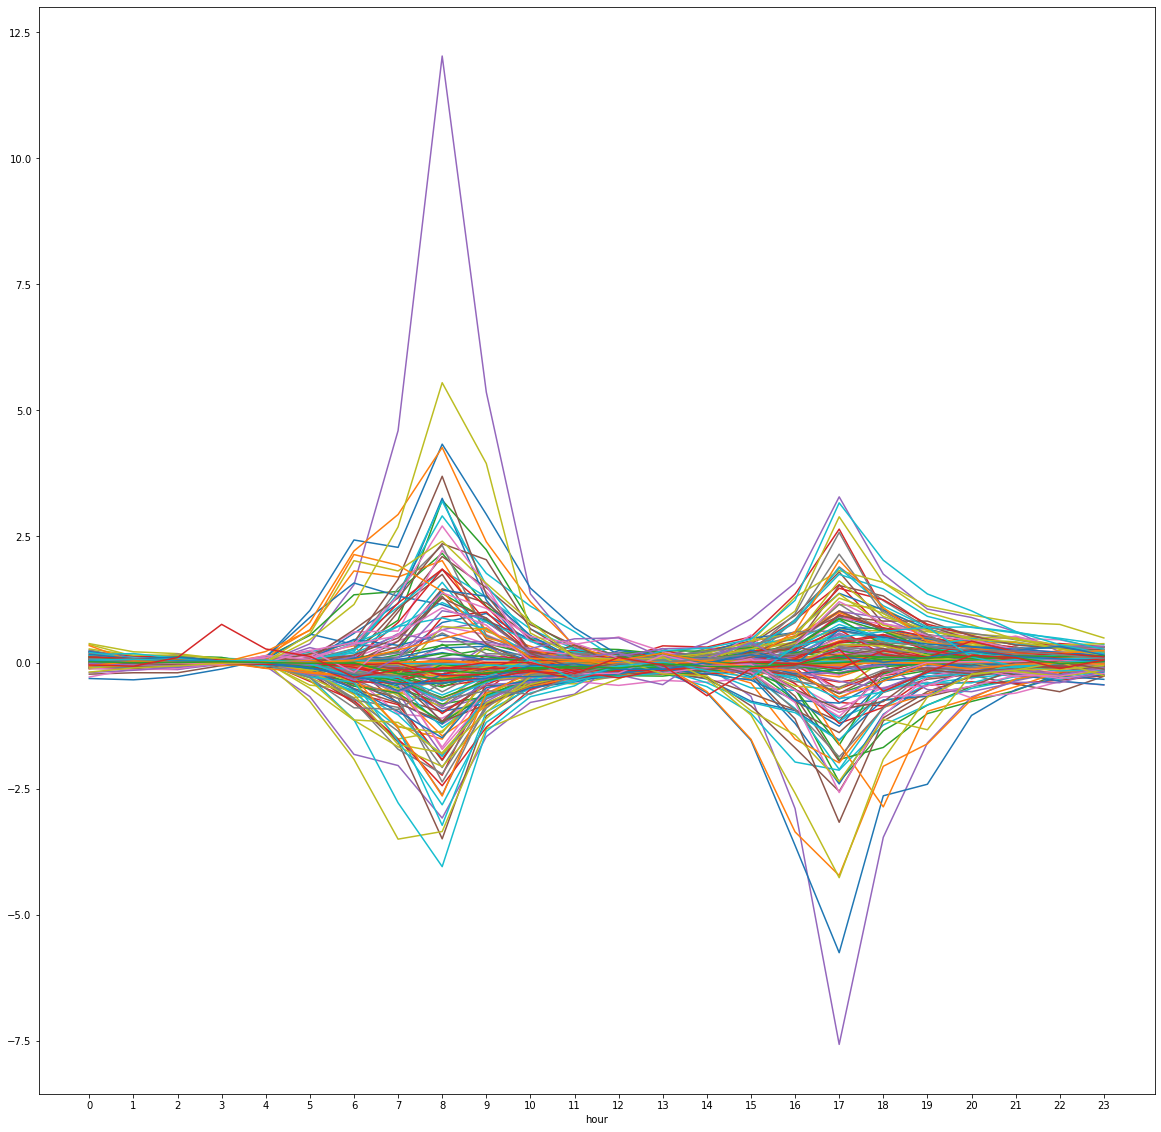

In [69]:
plt.figure(figsize=(20,20))
for key in station_frames:
    value = station_frames[key]
    value['hour'] = value.index.hour
    value.groupby('hour')['flow'].agg('mean').plot()
plt.xticks(np.arange(24))
plt.show()

<AxesSubplot:xlabel='hour'>

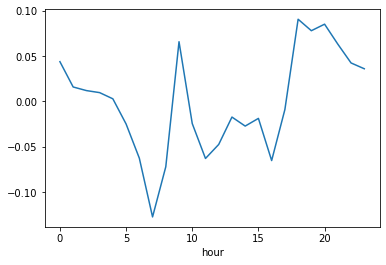

In [95]:
joined.groupby(['hour'])['flow'].agg('mean').plot()